# Sfepyによる動解析

第14回オープンCAE勉強会@関東（構造など）

# 自己紹介
藤田　拓生

CAE (Computer Aided Engineering)エンジニア
某CAEベンダー勤務、受託解析、ソルバーのユーザーサブルーチン作成などを担当

ブログ→http://plaza.rakuten.co.jp/takupin/
<br>
twitter→@pyontaku14
<br>
facebook→https://www.facebook.com/takuo.fujita.9

# 本日の内容

- Sfepyとは
- 片持ち梁の過渡応答解析
- 変位時刻歴のフーリエ変換
- 片持ち梁の固有値解析

# Sfepyとは

Simple Finite Elements in Python


<b>偏微分方程式を有限要素法を使って解くことにpythonを適用</b><br>

http://sfepy.org/doc-devel/index.html
<br>
sfepyの概要.pdf, 2015年9月12日　第05回オープンCAE勉強会＠関東（構造など）資料
<br>
SfePy: Simple Finite Elements in Python の紹介, 2016年11月26日 オープン CAE シンポジウム 2016@東京 講演会

# 06.03.2018 Version 2018.1 released

<b>時間ステップソルバーが更新→新例題 elastodynamics</b><br>

major update of time-stepping solvers and solver handling, <b><u>Newmark and Bathe elastodynamics solvers</u></b>, interface to MUMPS linear solver, new examples: iron plate impact problem (elastodynamics), incompressible Mooney-Rivlin material model (hyperelasticity) as a script, etc.), see release notes.

http://sfepy.org/doc-devel/news.html

http://sfepy.org/doc-devel/examples/linear_elasticity/elastodynamic.html

# 片持ち梁の過渡応答解析

<img src="fig1.png">

In [3]:
!type elastodynamic_mesh_steel.py

r"""
The linear elastodynamics solution of an iron plate impact problem.

Find :math:`\ul{u}` such that:

.. math::
    \int_{\Omega} \rho \ul{v} \pddiff{\ul{u}}{\ul{v}}
    + \int_{\Omega} D_{ijkl}\ e_{ij}(\ul{v}) e_{kl}(\ul{u})
    = 0
    \;, \quad \forall \ul{v} \;,

where

.. math::
    D_{ijkl} = \mu (\delta_{ik} \delta_{jl}+\delta_{il} \delta_{jk}) +
    \lambda \ \delta_{ij} \delta_{kl}
    \;.

Notes
-----

The used elastodynamics solvers expect that the total vector of DOFs contains
three blocks in this order: the displacements, the velocities, and the
accelerations. This is achieved by defining three unknown variables ``'u'``,
``'du'``, ``'ddu'`` and the corresponding test variables, see the `variables`
definition. Then the solver can automatically extract the mass, damping (zero
here), and stiffness matrices as diagonal blocks of the global matrix. Note
also the use of the ``'dw_zero'`` (do-nothing) term that prevents the
velocity-related variables to be removed from the eq

In [4]:
%run simple.py elastodynamic_mesh_steel.py

sfepy: left over: ['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'absolute_import', 'nm', 'mc', 'data_dir', 'plane', 'dim', 'E', 'nu', 'rho', 'lam', 'mu', 'cl', 'cs', 'v0', 'H', 'dt', 't1', 'post_process', 'get_ic', 'verbose', '_filename']
sfepy: reading mesh [line2, tri3, quad4, tetra4, hexa8] (C:\Users\pyont\sfepy\block_1m.mesh)...
sfepy: ...done in 0.02 s
sfepy: creating regions...
sfepy:     Omega
sfepy:     left
sfepy: ...done in 0.02 s
sfepy: equation "balance_of_forces":
sfepy: dw_volume_dot.i.Omega(solid.rho, ddv, ddu)
     + dw_zero.i.Omega(dv, du)
     + dw_lin_elastic.i.Omega(solid.D, v, u) = 0
sfepy: using solvers:
                ts: tsn
               nls: newton
                ls: ls
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (4725, 4725)
sfepy: assembling matrix graph...
sfepy: ...done in 0.04 s
sfepy: matrix structural nonz

実行後、h5ファイルができていることを確認。
h5をvtkに変換

In [5]:
%run extractor.py -d block_1m.h5

sfepy: dumping to VTK...
sfepy:   reading mesh [user] (block_1m.h5)...
sfepy:   ...done in 0.01 s
sfepy:    0 of 10
sfepy:    1 of 10
sfepy:    2 of 10
sfepy:    3 of 10
sfepy:    4 of 10
sfepy:    5 of 10
sfepy:    6 of 10
sfepy:    7 of 10
sfepy:    8 of 10
sfepy:    9 of 10
sfepy:   10 of 10
sfepy: ...done


In [0]:
!convert block_1m.*.png block_1m.gif

<img src="block_1m.gif">

計算対象時間を長くして計算実行<br>

#termination time<br>
t1 = 16384.0 * H / cl

変位時刻歴をscipy fftpackでフーリエ変換

In [7]:
!type fftpack.py

import numpy as np
import pandas as pd
from scipy import fftpack
import matplotlib.pyplot as plt

df=pd.read_csv("Uy0a.csv")
dt=8.510498e-06
n=len(df)

#time domain
t=np.linspace(0,n*dt,n)
yt=df.iloc[:,0]

#fft
yf=fftpack.fft(yt)/(n/2.0)
freq=fftpack.fftfreq(n,dt)

#plot
plt.plot(t,yt)
plt.ylabel("Uy [m]")
plt.xlabel("Time [sec]")
plt.show()
plt.plot(freq[1:n//2], np.angle(yf[1:n//2])*180.0/np.pi)
plt.xlim(0,6000)
plt.ylabel("Phase [deg]")
plt.show()
plt.plot(freq[1:n//2], np.abs(yf[1:n//2]))
plt.xlim(0,6000)
plt.ylim(1.0e-9,1.0e-2)
plt.yscale("log")
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.annotate('163.5Hz', xy=(1.635178765297e+02, 1.0E-4), xytext=(1.635178765297e+02, 1.0E-3),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('886.4Hz', xy=(8.863935606048e+02, 1.0E-5), xytext=(8.863935606048e+02, 1.0E-4),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.annotate('2129.5Hz', xy=(2.129515131439e+03, 1.0

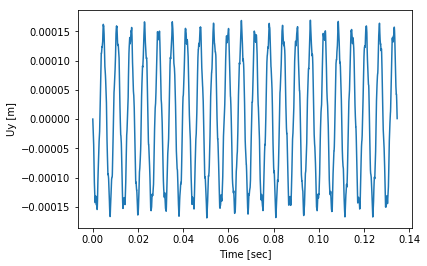

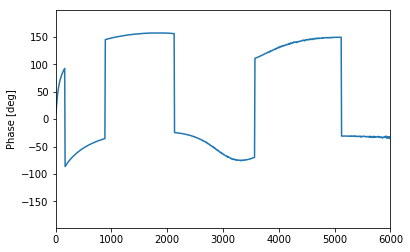

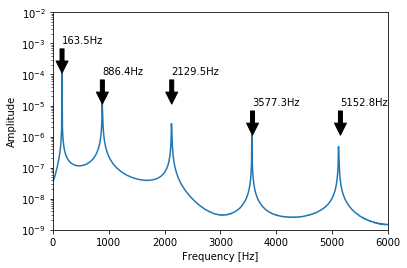

In [0]:
%run fftpack.py

固有値解析を実施

In [8]:
!type modal_analysis_cantilever_steel.py

#!/usr/bin/env python
"""
Modal analysis of a linear elastic block in 2D or 3D.

The dimension of the problem is determined by the length of the vector
in ``--dims`` option.

Optionally, a mesh file name can be given as a positional argument. In that
case, the mesh generation options are ignored.

The default material properties correspond to aluminium in the following units:

- length: m
- mass: kg
- stiffness / stress: Pa
- density: kg / m^3

Examples
--------

- Run with the default arguments, show results (color = strain)::

    python examples/linear_elasticity/modal_analysis.py --show

- Fix bottom surface of the domain, show 9 eigen-shapes::

    python examples/linear_elasticity/modal_analysis.py -b cantilever -n 9 --show

- Increase mesh resolution::

    python examples/linear_elasticity/modal_analysis.py -s 31,31 -n 9 --show

- Use 3D domain::

    python examples/linear_elasticity/modal_analysis.py -d 1,1,1 -c 0,0,0 -s 8,8,8 --show

- Change the eigenvalue problem solver to

In [0]:
%run modal_analysis_cantilever_steel.py -n 10

sfepy: using values:
sfepy:   Young's modulus: 200000000000.0
sfepy:   Poisson's ratio: 0.3
sfepy:   density: 7800.0
sfepy: displacement field approximation order: 1
sfepy: requested 10 eigenvalues
sfepy: using eigenvalue problem solver: eig.scipy
sfepy:   method: 'eigh'
sfepy:   tol: 1e-05
sfepy:   maxiter: 1000
sfepy: reading mesh [line2, tri3, quad4, tetra4, hexa8] (block_1m.mesh)...
sfepy: ...done in 0.00 s
sfepy: axis:       -1
sfepy: updating variables...
sfepy: ...done
sfepy: setting up dof connectivities...
sfepy: ...done in 0.00 s
sfepy: matrix shape: (1500, 1500)
sfepy: assembling matrix graph...
sfepy: ...done in 0.03 s
sfepy: matrix structural nonzeros: 88218 (3.92e-02% fill)
sfepy: updating materials...
sfepy:     m
sfepy: ...done in 0.01 s
sfepy: 10 eigenvalues converged (0 ignored as rigid body modes)
sfepy: number |         eigenvalue |  angular frequency |          frequency
sfepy:      1 | 1.055577717654e+06 | 1.027413119273e+03 | 1.635178765297e+02
sfepy:      2 | 2.

<img src="katamochihari.png">
lambda	1.8751<br>
l	1<br>
E	2.00E+11<br>
I	0.0001333333<br>
rho	7.80E+03<br>
A	0.04<br>
fo	<b>163.5972761104</b> (１次振動数の理論値)

<font size="4">
sfepy: 10 eigenvalues converged (0 ignored as rigid body modes)<br>
sfepy: number |         eigenvalue |  angular frequency |          frequency<br>
sfepy:      1 | 1.055577717654e+06 | 1.027413119273e+03 | 1.635178765297e+02<br>
sfepy:      2 | 2.177805847553e+07 | 4.666696741329e+03 | 7.427278542933e+02<br>
sfepy:      3 | 3.101793785020e+07 | 5.569374996370e+03 | 8.863935606048e+02<br>
sfepy:      4 | 6.425318421113e+07 | 8.015808394113e+03 | 1.275755528801e+03<br>
sfepy:      5 | 1.790280978570e+08 | 1.338013818527e+04 | 2.129515131439e+03<br>
sfepy:      6 | 1.970176881531e+08 | 1.403629894784e+04 | 2.233946360264e+03<br>
sfepy:      7 | 5.052098054363e+08 | 2.247687267918e+04 | 3.577305392139e+03<br>
sfepy:      8 | 5.529440062786e+08 | 2.351476145485e+04 | 3.742490521167e+03<br>
sfepy:      9 | 5.749316657433e+08 | 2.397773270648e+04 | 3.816174684372e+03<br>
sfepy:     10 | 1.048211433630e+09 | 3.237609355111e+04 | 5.152815326664e+03<br>
</font>

1.635178765297e+02Hz
<img src="eigen0.gif">

8.863935606048e+02Hz
<img src="eigen2.gif">

2.129515131439e+03Hz
<img src="eigen4.gif">

3.577305392139e+03Hz
<img src="eigen6.gif">

5.152815326664e+03Hz
<img src="eigen9.gif">

# まとめ

* sfepyを使って片持ち梁の過渡応答解析を実施した。
* 十分な長さの時間(定常状態)の変位時刻歴をフーリエ変換することにより、周波数応答解析になることを確認した。
* 固有値解析を実施し、ピーク周波数のモードを確認した。
* 1次の固有振動数は理論値とほぼ一致することを確認した。

gifの作成方法で参考になったURL
http://freeplanets.ship.jp/index.html

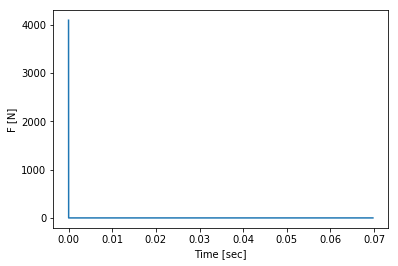

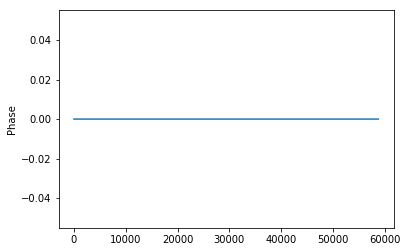

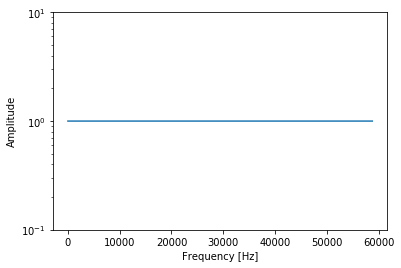

In [2]:
#単位インパルスのフーリエ変換

import numpy as np
import pandas as pd
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

dt=8.510498e-06
n=8192

#time domain
t=np.linspace(0,n*dt,n)
yt=np.zeros(n)
yt[0]=n/2 #データ長の1/2

#fft
yf=fftpack.fft(yt)/(n/2.0)
freq=fftpack.fftfreq(n,dt)

#plot
plt.plot(t,yt)
plt.ylabel("F [N]")
plt.xlabel("Time [sec]")
plt.show()
plt.plot(freq[1:n//2], np.angle(yf[1:n//2]))
plt.ylabel("Phase")
plt.show()
plt.plot(freq[1:n//2], np.abs(yf[1:n//2]))
#plt.xlim(0,6000)
plt.ylim(1.0e-1,1.0e+1)
plt.yscale("log")
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")         
plt.show()#単位インパルスのフーリエ変換

加振実験のたたく動作は、インパルスにより、あらゆる周波数成分を等しく入力する。
http://www.kimura-lab.net/2010/10/23/%E3%83%8F%E3%83%B3%E3%83%9E%E3%83%AA%E3%83%B3%E3%82%B0%E3%83%86%E3%82%B9%E3%83%88/